# **ML-AI4Econ Course**

We first download the different packages needed for this part of the course:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report, confusion_matrix

We also set a random seed for reproducible results:

In [2]:
np.random.seed(24)

### Regression Decision Trees

One of the most interpretable and easy-to-understand algorithms are binary decision trees. Decision trees are just what they sound like, they are (inverted) trees for which each branch in the tree has some decision rule with respect to some variable that allows to classify an observation to one or another region and, at the last "leaf", we make a prediction depending on the resulting region.

We have both regression and classification trees, so we can use this algorithm for both tasks. However, there are different aspects that are interesting to explore when estimating these models. For this purpose, we use two different datasets on go through a complete process to estimate an optimized model for our data.

Of course, we first start by downloading the data, and then we go to regression trees to finish with classification trees.

In [3]:
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

print("Dataset description:\n", data.DESCR)
print("\nThese are the original explanatory variables:\n\n",X,"\n")
print("\nThese are the prices for each observation (the target variable):\n\n",y,"\n")

Dataset description:
 .. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census

As always, we divide the sample in train and test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

First, we will estimate a regression decision tree with the default hyperparameters and a cross-validation error estimate to check the performance of an "automatic model". That is, a model in which we do not tune hyperparameters nor modify different aspects of the tree.

In [5]:
dtree = DecisionTreeRegressor(random_state=42)
dtree.fit(X_train, y_train)

# Which is the estimation for the generalization error?

cv_scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -np.mean(cv_scores)
print("Cross-validated MSE (initial tree): {:.4f}".format(cv_mse),"\n")

# Let us see the test performance

y_pred = dtree.predict(X_test)
mae_initial = mean_absolute_error(y_test, y_pred)
mse_initial = mean_squared_error(y_test, y_pred)
r2_initial = r2_score(y_test, y_pred)
print("Initial Decision Tree Performance:\n")
print("MSE: {:.4f}".format(mse_initial))
print("MAE: {:.4f}".format(mae_initial))
print("R^2: {:.4f}".format(r2_initial))

Cross-validated MSE (initial tree): 0.5246 

Initial Decision Tree Performance:

MSE: 0.4952
MAE: 0.4547
R^2: 0.6221


We can see how does the tree look like through an special plot:

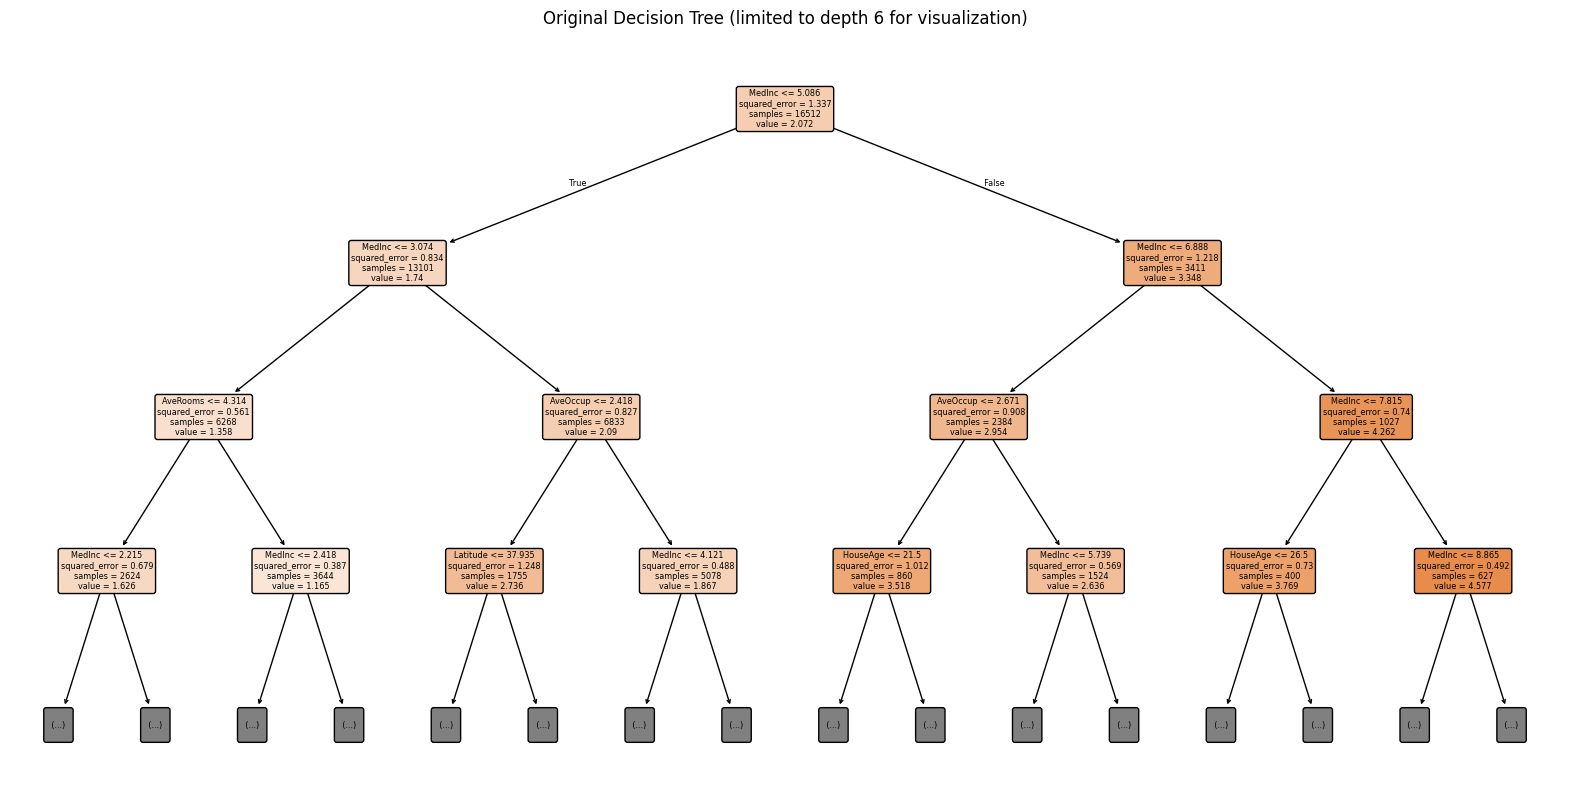

In [6]:
plt.figure(figsize=(20,10))
plot_tree(dtree, feature_names=X.columns, filled=True, rounded=True, max_depth=3)
plt.title("Original Decision Tree (limited to depth 6 for visualization)")
plt.show()

We can try to improve our model by changing the hyperparameters and elements of our tree. One of the most important ones might be the depth of the tree, which can be understood as how many decision rules or branches should our tree have. By balancing the training error and complexity through cost complexity prunning, we might obtain better generalization performance and avoid overfitting.

The effective cost of a tree $T$ is defined as:

$$
\text{Cost}(T) = \text{Error}(T) + \alpha \times \text{Complexity}(T)
$$

where:
- $\text{Error}(T)$ is the error measure (such as the sum of squared errors for regression or misclassification error for classification).
- $\text{Complexity}(T)$ is typically related to the number of terminal nodes (leaves) in the tree.
- $\alpha$ is a tuning parameter that controls the trade-off between the model’s fit and its complexity.

A higher value of $\alpha$ penalizes complex trees more, leading to a simpler tree by removing splits (branches) that do not contribute significantly to reducing the error.

In summary, pruning removes branches that capture noise rather than useful patterns, resulting in a more robust model that is less likely to overfit the training data.



Number of candidate alphas for pruning:  14833


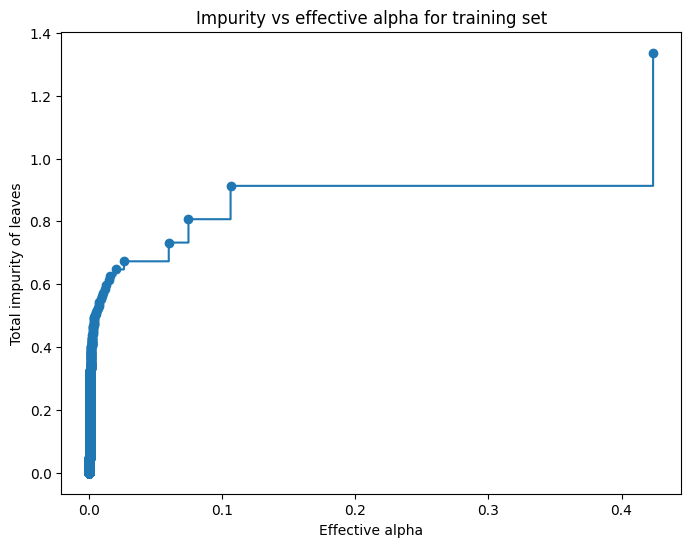

In [7]:
path = dtree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print("\nNumber of candidate alphas for pruning: ", len(ccp_alphas))

plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Impurity vs effective alpha for training set")
plt.show()

In [8]:
param_grid = {'ccp_alpha': np.linspace(ccp_alphas[1], ccp_alphas[-1], num=10)}  # skip the first alpha=0
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['ccp_alpha']
print("\nBest alpha from GridSearchCV: ", best_alpha)

pruned_tree = grid_search.best_estimator_

# Performance evaluation

y_pred_pruned = pruned_tree.predict(X_test)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
mae_pruned = mean_absolute_error(y_test, y_pred_pruned)
r2_pruned = r2_score(y_test, y_pred_pruned)
print("\nPruned Decision Tree Performance:\n")
print("MSE: {:.4f}".format(mse_pruned))
print("MAE: {:.4f}".format(mae_pruned))
print("R^2: {:.4f}".format(r2_pruned))


Best alpha from GridSearchCV:  5.378987522408704e-20

Pruned Decision Tree Performance:

MSE: 0.4952
MAE: 0.4547
R^2: 0.6221


We can now take a look at the prunned tree:

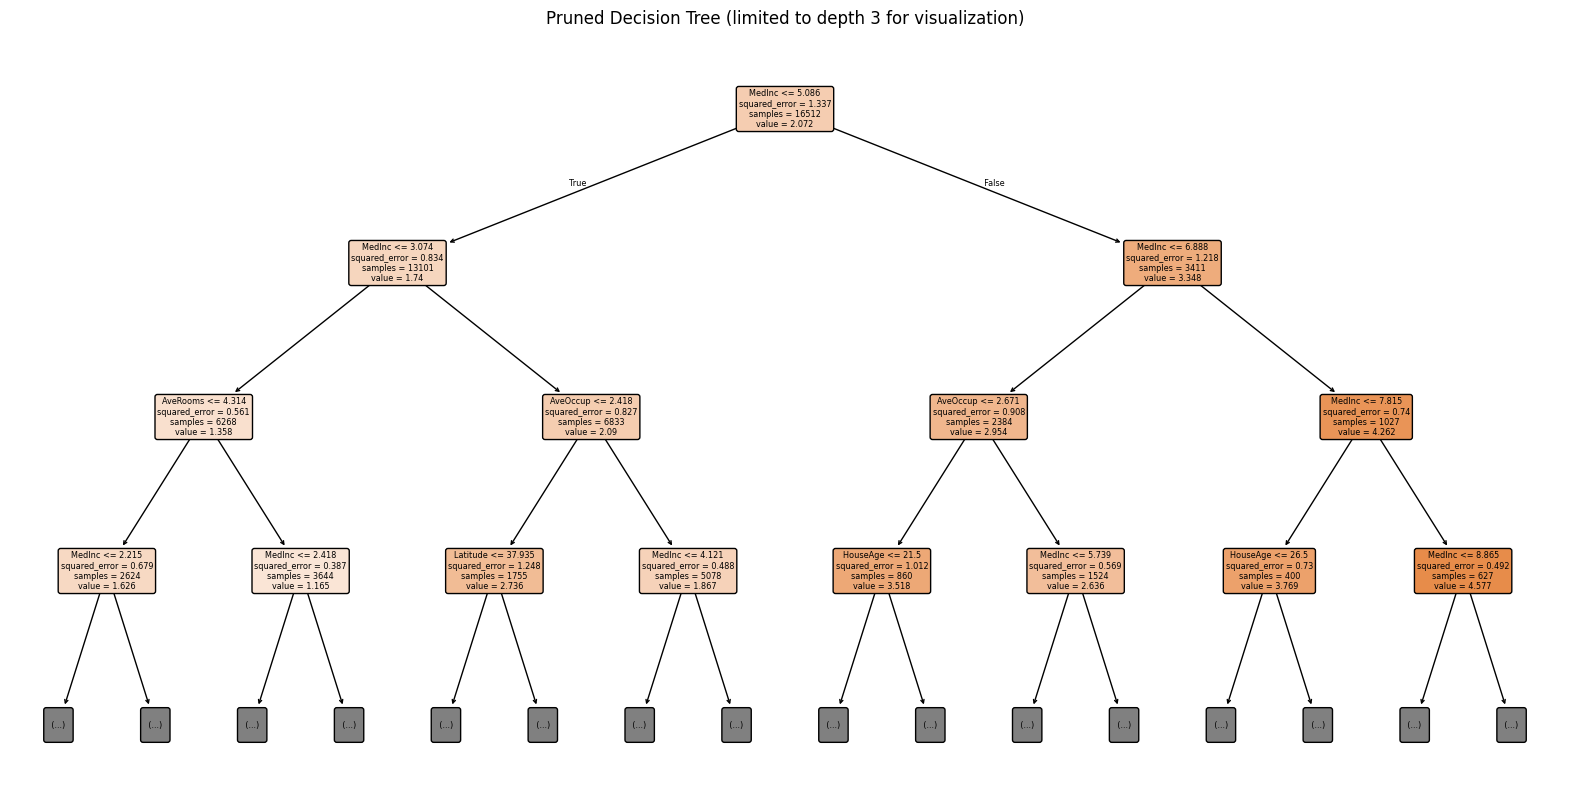

In [9]:
plt.figure(figsize=(20,10))
plot_tree(pruned_tree, feature_names=X.columns, filled=True, rounded=True, max_depth=3)
plt.title("Pruned Decision Tree (limited to depth 3 for visualization)")
plt.show()

Seems like we have improved our test performance. However, we can still optimize other hyperparameters to have better performance. Let us see what happens when we tweak other parameters, such as maximum depth or the number of samples per node/leaf.

In [10]:
param_grid = {'ccp_alpha': np.linspace(ccp_alphas[1], ccp_alphas[-1], num=10),
                  'max_depth': [None, 5, 10, 15, 20],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4]}  # skip the first alpha=0
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['ccp_alpha']
print("\nBest alpha from GridSearchCV: ", best_alpha)

pruned_tree = grid_search.best_estimator_

# Performance evaluation

y_pred_pruned = pruned_tree.predict(X_test)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
mae_pruned = mean_absolute_error(y_test, y_pred_pruned)
r2_pruned = r2_score(y_test, y_pred_pruned)
print("\nPruned Decision Tree Performance:\n")
print("MSE: {:.4f}".format(mse_pruned))
print("MAE: {:.4f}".format(mae_pruned))
print("R^2: {:.4f}".format(r2_pruned))


Best alpha from GridSearchCV:  5.378987522408704e-20

Pruned Decision Tree Performance:

MSE: 0.4084
MAE: 0.4311
R^2: 0.6883


We can now take a look at the tuned tree:

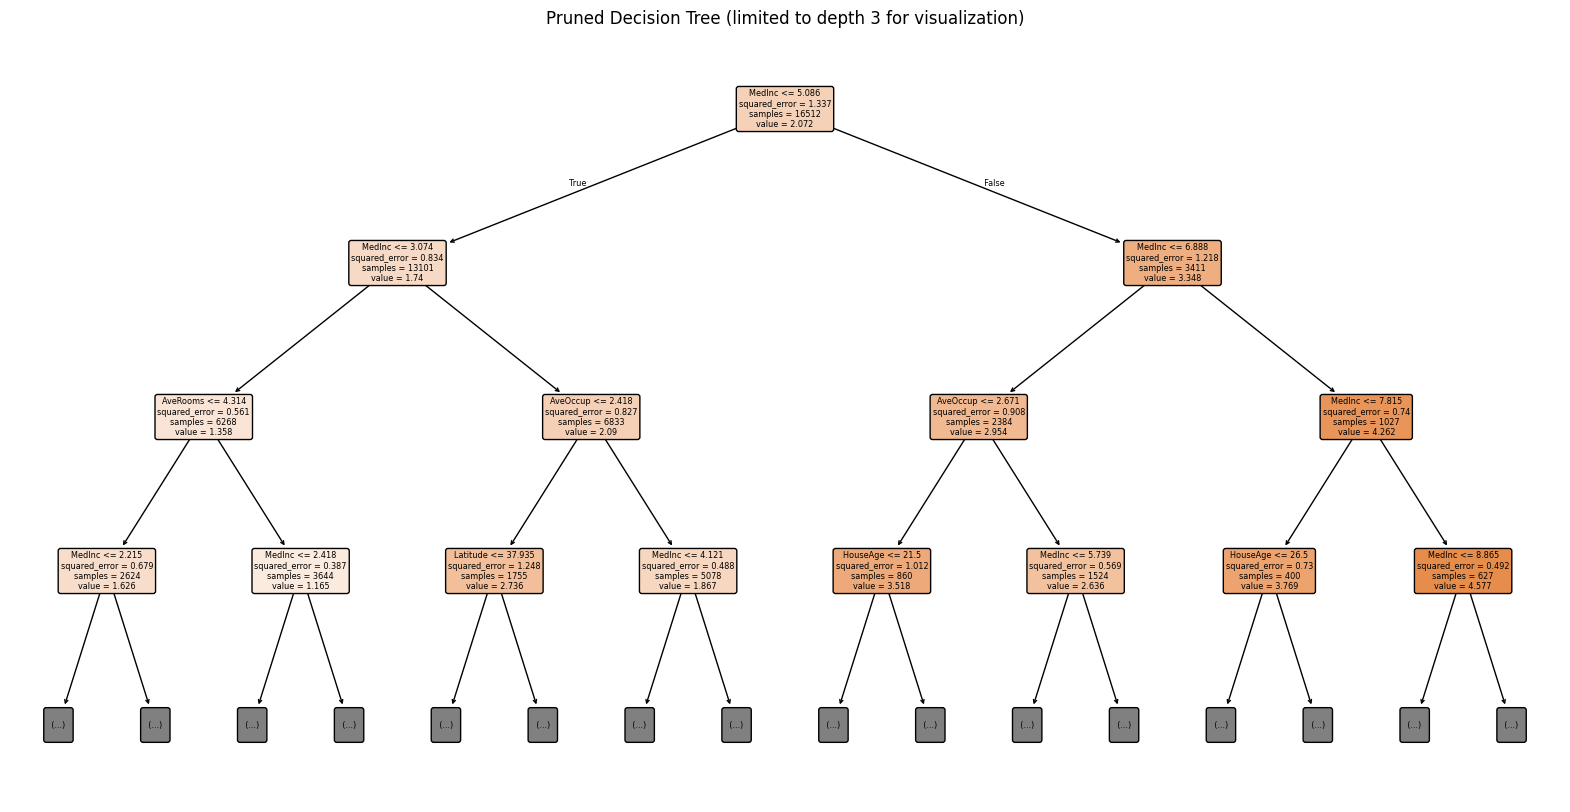

In [11]:
plt.figure(figsize=(20,10))
plot_tree(pruned_tree, feature_names=X.columns, filled=True, rounded=True, max_depth=3)
plt.title("Pruned Decision Tree (limited to depth 3 for visualization)")
plt.show()

In fact, we can even compute which variables are more important variables thorugh a concept called **feature importance**. In decision trees and ensemble methods like Random Forests, feature importance is computed based on the idea of **impurity reduction**. Here's a breakdown of the process:

1. **Impurity Measures:**  

   - For **classification trees**, impurity is commonly measured using the **Gini impurity** or **entropy**.  
   - For **regression trees**, impurity is typically measured as the **variance** (often via Mean Squared Error).

2. **Impurity Decrease at a Node:**  

   When a node splits, the goal is to reduce the impurity. The decrease in impurity resulting from a split is calculated as:

   $$
   \Delta I = I(\text{parent}) - \sum_{i=1}^{k} \frac{N_i}{N_{\text{parent}}} \, I(i)
   $$

   where:  
   - $I(\text{parent})$ is the impurity of the parent node,  
   - $I(i)$ is the impurity of the $i$-th child node,  
   - $N_i$ is the number of samples in the $i$-th child,  
   - $N_{\text{parent}}$ is the total number of samples in the parent node, and  
   - $k$ is the number of child nodes (usually 2 in binary trees).

3. **Assigning Importance to Features:**

   The improvement (or decrease) in impurity $\Delta I$ is attributed to the feature used to split the node. This improvement is typically **weighted** by the fraction of samples reaching that node.

4. **Aggregating Over the Entire Tree:**  

   The importance for each feature is computed by summing the weighted impurity decreases for all nodes where that feature is used. Finally, these values are normalized so that the importances for all features add up to 1 (or 100%).

In essence, a feature is considered important if it consistently leads to large reductions in impurity across many nodes in the tree. Hence, let us see which variable allows to separate observations the most.

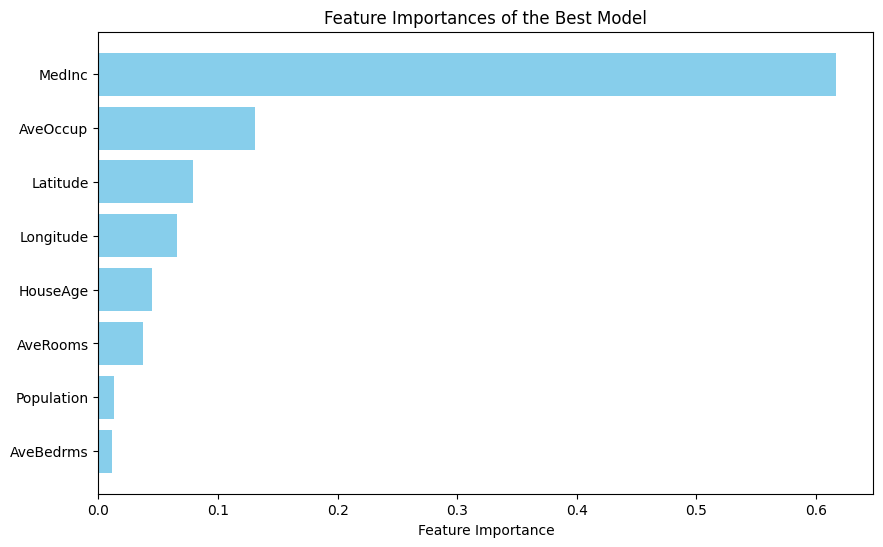

In [12]:
feature_importances = pruned_tree.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importances of the Best Model")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

### Classification Decision Trees

Now that we have seen a simple workflow applied to regression decision trees, we can now delve into classification tasks with this algorithm. We will use a different dataset, but we will still use the same workflow than that for the regression tree. We just want to look at an example for classification, but it is merely the same.

In [13]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print("Dataset Description:\n\n")
print(data.DESCR)
print("\nFeatures:\n\n")
print(X.head())
print("\nTarget:\n\n")
print(y.head())

Dataset Description:


.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 i

We now split the dataset:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Now, we compute first a simple tree, as before, to compare it to a tuned model afterwards:

In [15]:
simple_tree = DecisionTreeClassifier(random_state=42)
simple_tree.fit(X_train, y_train)

# Evaluate the simple model on the test set

y_pred_simple = simple_tree.predict(X_test)
accuracy_simple = accuracy_score(y_test, y_pred_simple)
print("\nSimple Decision Tree Performance:")
print("Accuracy: {:.4f}".format(accuracy_simple))
print("\nClassification Report:\n", classification_report(y_test, y_pred_simple))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_simple))


Simple Decision Tree Performance:
Accuracy: 0.9474

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114


Confusion Matrix:
 [[40  3]
 [ 3 68]]


The resulting tree will be the following:

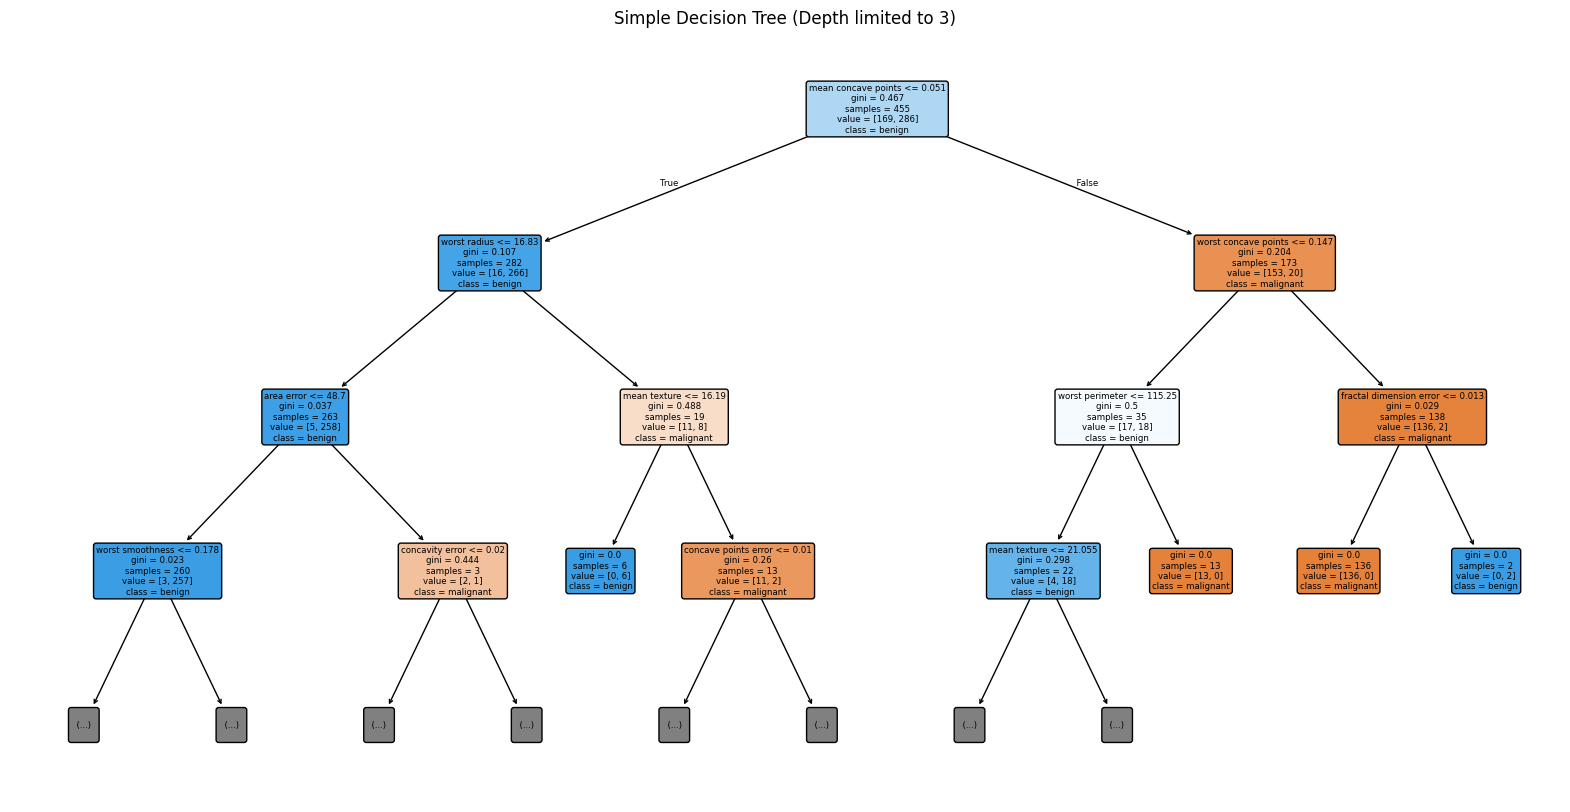

In [16]:
plt.figure(figsize=(20,10))
plot_tree(simple_tree, feature_names=X.columns, class_names=data.target_names,
          filled=True, rounded=True, max_depth=3)
plt.title("Simple Decision Tree (Depth limited to 3)")
plt.show()

Now, we providde a tuned model which should improve the test performance:

In [17]:
path = simple_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
print("\nNumber of candidate alphas for pruning: ", len(ccp_alphas))

alpha_candidates = np.linspace(ccp_alphas[1], ccp_alphas[-1], num=10)

param_grid = {
    'ccp_alpha': alpha_candidates,
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_tree = grid_search.best_estimator_

print("\nBest Parameters from GridSearchCV:")
print(best_params)

# Performance Evaluation

y_pred_tuned = best_tree.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("\nTuned Decision Tree Performance:")
print("Accuracy: {:.4f}".format(accuracy_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))


Number of candidate alphas for pruning:  13

Best Parameters from GridSearchCV:
{'ccp_alpha': 0.00218083075225933, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

Tuned Decision Tree Performance:
Accuracy: 0.9474

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114


Confusion Matrix:
 [[40  3]
 [ 3 68]]


This tree looks like this:

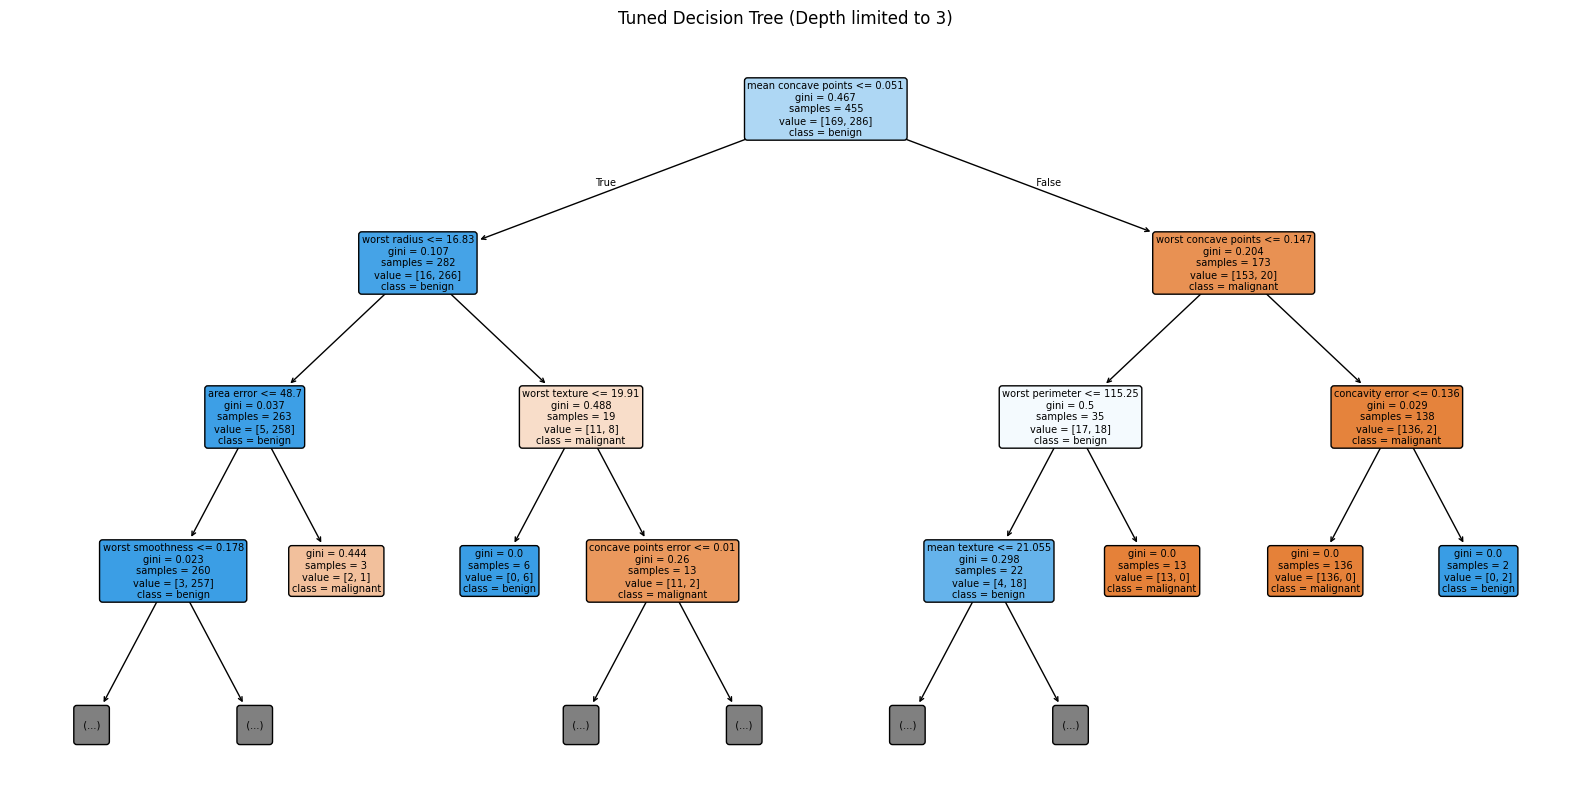

In [18]:
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X.columns, class_names=data.target_names,
          filled=True, rounded=True, max_depth=3)
plt.title("Tuned Decision Tree (Depth limited to 3)")
plt.show()

For this tuned model, we can see which are the most important variables through the feature importance plot:

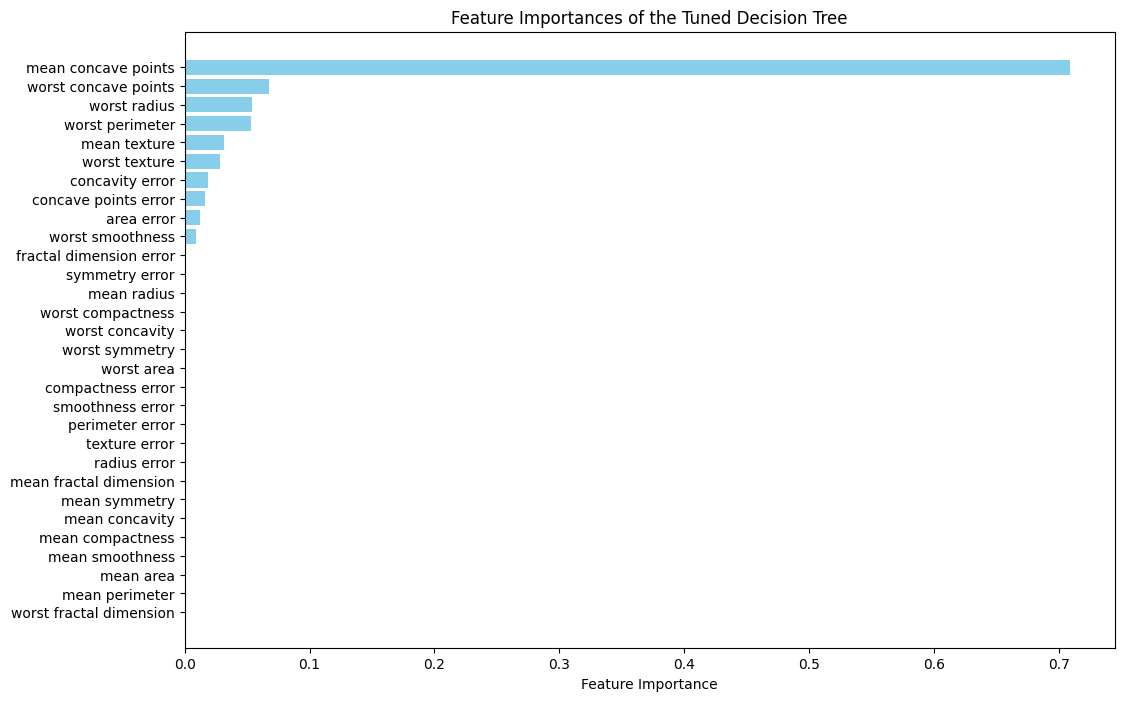

In [19]:
feature_importances = best_tree.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importances of the Tuned Decision Tree")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Exercises

Now there are a bunch of exercises for testing your understanding. Please do not use LLMs or ChatGPT to answer them (unless you are explicitly ordered to do so), but look at the documentation of different packages and websites for a better control of Python packages for ML \& AI.

### **Exercise 1: Understanding Trees**
**Objective:** Understand the mechanics of a decision tree.

- What happens when we do not restrict the depth of a tree and go for the maximum branching possible?
- What would be the prediction of the leafs in each case?
- Seems like the value predicted for a parent node of the regression tree is higher than the one predicted for one branch and lower for the other. Why is that?
- Does the cost complexity prunning formula remind you of some method we used for regressions?
- What does impurity measure, given the functions used for its computation? Why do we want to reduce it?

### **Exercise 2: Hyperparameter Tuning and Model Evaluation**  
**Objective:** Explore the impact of hyperparameters on the performance of decision trees.  
- Train an unpruned decision tree on a another regression dataset and record its performance metrics (MSE, MAE, R²) on both the training and test sets.  
- Use GridSearchCV to tune key hyperparameters such as `ccp_alpha`, `max_depth`, `min_samples_split`, and `min_samples_leaf`. What are the best parameters found?  
- Compare the performance of the tuned model with that of the unpruned model. What improvements do you observe, and why might these improvements occur?

### **Exercise 3: Feature Importance and Model Interpretation**  
**Objective:** Understand and interpret feature importance in tree-based models.  
- After tuning your decision tree regressor, extract the feature importances using the `feature_importances_` attribute.  
- Create a horizontal bar chart that visualizes the importance of each feature.  
- Identify the top three most important features and discuss why they might be influential in predicting the target variable.  
- Suggest ways you might use this information to further improve the model (e.g., by selecting features or engineering new ones).

### **Exercise 4: Classification with Decision Trees**  
**Objective:** Apply decision trees for classification and evaluate model performance.  
- Using a another classification dataset, train a simple decision tree classifier.  
- Evaluate the model using accuracy, precision, recall, F1 score, and by constructing a confusion matrix.  
- Perform hyperparameter tuning, including cost complexity pruning, with GridSearchCV to optimize the classifier's performance.  
- Compare the performance of the simple classifier with that of the tuned classifier. What differences do you observe?

### **Exercise 5: Comparing Linear and Non-linear Classification Methods**  
**Objective:** Compare logistic regression with LDA and QDA on a classification task.  
- Train a logistic regression model on the Iris dataset and evaluate its performance.  
- Train LDA and QDA models on the same dataset.  
- Use PCA (if necessary) to reduce the feature space to 2 dimensions, and visualize the decision boundaries of each model.  
- Discuss the differences in performance and decision boundaries. Which model seems to perform best and why might that be the case?

### **Exercise 6: Overfitting, Underfitting, and the Role of Pruning**  
**Objective:** Understand the concepts of overfitting and underfitting in decision trees and how pruning can help.  
- On a regression dataset, train decision trees with varying values of `max_depth` and observe how the training and test errors change.  
- Plot the training error and test error as functions of tree depth. At what point do you notice signs of overfitting?  
- Apply cost complexity pruning to your tree, and compare the performance (using cross-validation) of the pruned tree to the unpruned tree.  
- Explain how pruning helps achieve a better bias-variance tradeoff and why this is beneficial for generalization.